# Feature extraction from images

The generative AI part of this notebook requires an AWS account with bedrock models enabled.

In [12]:
%pip install -q -r requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import ipywidgets as widgets
from IPython.display import display, Markdown, JSON, clear_output
import textwrap
import helpers as aws
import os, json
from tabulate import tabulate
import cv2 
import matplotlib.pyplot as plt 
from contextlib import contextmanager
import textwrap
import numpy as np

local_images = [f for f in os.listdir('.') if f.endswith('.jpg')]

@contextmanager
def image_spinner(out):
    image = open('spinner.gif', 'rb').read()
    with out:
        clear_output()
        display(widgets.Image(value=image, width=100))
        yield
        clear_output()


def print_wrapped(text, width=80):
    for line in textwrap.wrap(text, width):
        print(line)

# Traditional Feature Engineering

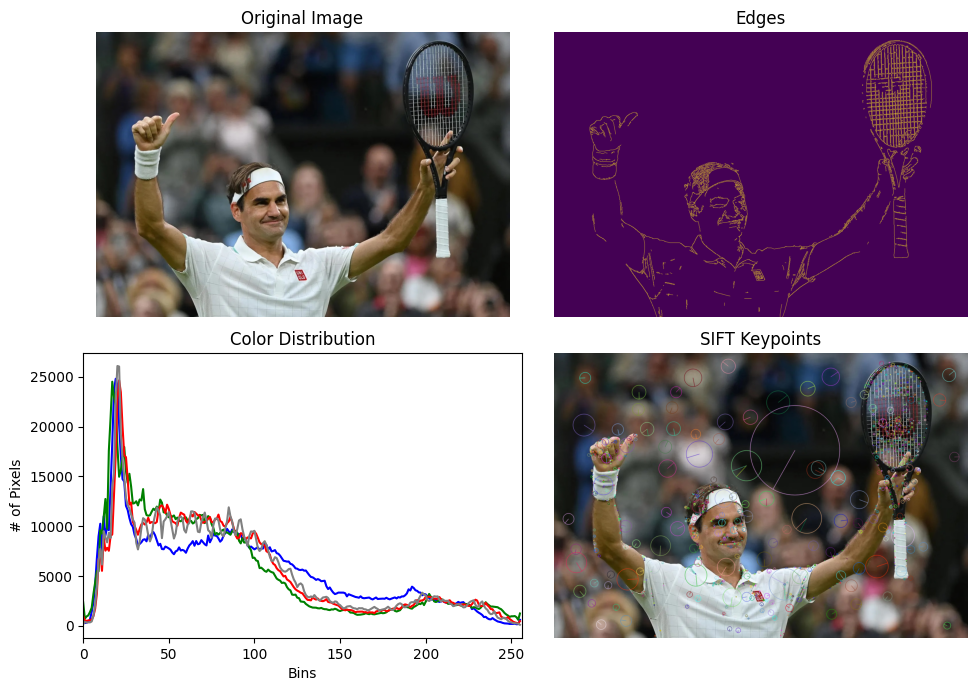

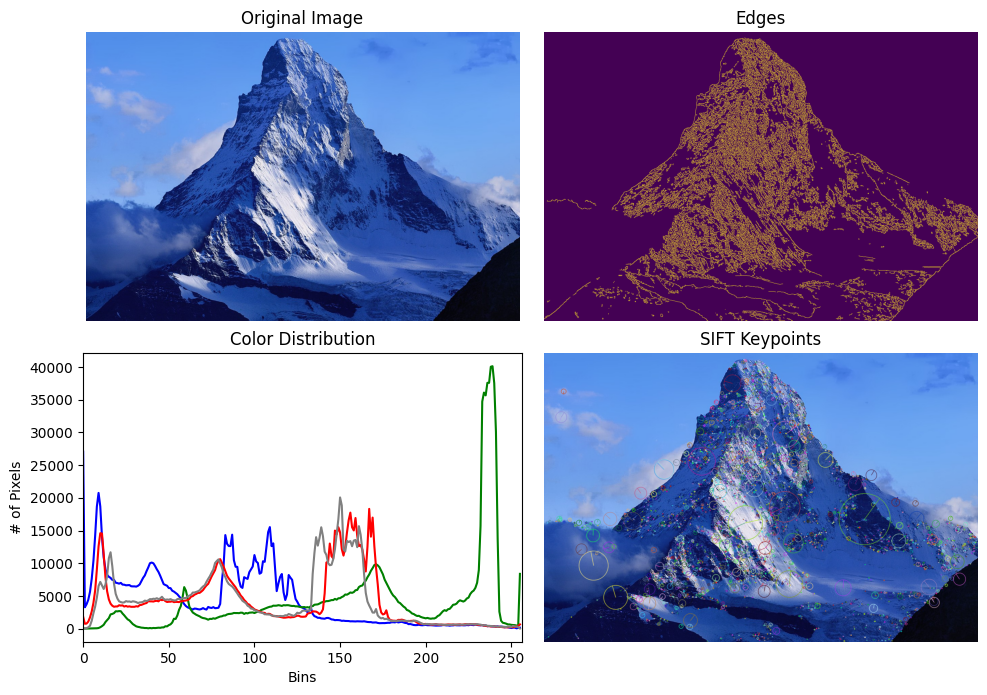

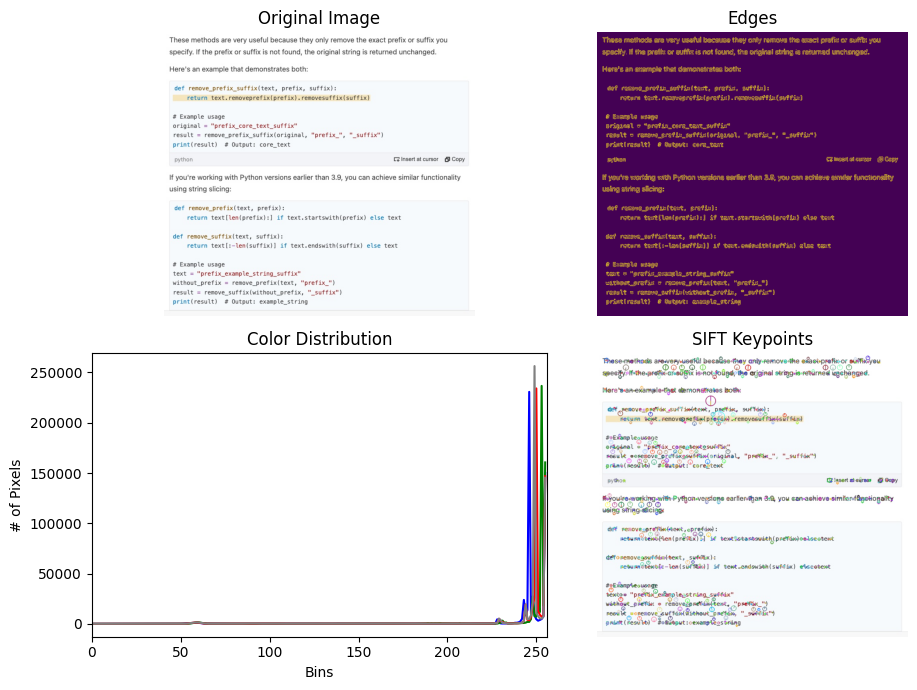

12


In [4]:
def plot_image_edges(file):
    # Load the image
    image = cv2.imread(file) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Display the original image and the edges
    plt.figure(figsize=(10,7))
    plt.subplot(2, 2, 1)
    plt.title('Original Image')
    plt.axis("off")
    plt.imshow(image)

    # display canny edges
    edges = cv2.Canny(gray, 100, 200)
    plt.subplot(2, 2, 2)
    plt.title('Edges')
    plt.axis("off")
    plt.imshow(edges)

    # display harris corners
    # dst = cv2.cornerHarris(gray, 3, 5, 0.1)
    # corners = dst > 0.05 * dst.max()
    # coord = np.argwhere(corners)
    # img = image.copy()
    # for y, x in coord:
    #     cv2.circle(img, (x, y), 3, (0, 0, 255), -1)

    # plt.subplot(2, 2, 3)
    # plt.title('Harris Corners')
    # plt.axis("off")
    # plt.imshow(img)

    # display color histogram
    blue_color = cv2.calcHist([image], [0], None, [256], [0, 256]) 
    red_color = cv2.calcHist([image], [1], None, [256], [0, 256]) 
    green_color = cv2.calcHist([image], [2], None, [256], [0, 256]) 
    gray_scale = cv2.calcHist([gray], [0], None, [256], [0, 256])

    # Separate Histograms for each color 
    plt.subplot(2, 2, 3)
    plt.title("Color Distribution") 
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    plt.plot(blue_color, color="blue")
    plt.plot(green_color, color="green")
    plt.plot(red_color, color="red")
    plt.plot(gray_scale, color="gray")
    plt.xlim([0, 256])

    # display sift features
    sift = cv2.SIFT_create()
    keypoints = sift.detect(gray, None)
    img = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.subplot(2, 2, 4)
    plt.title('SIFT Keypoints')
    plt.axis("off")
    plt.imshow(img)

    plt.tight_layout()
    plt.show()

for file in local_images:
    plot_image_edges(file)

print(12)

# GenAI based feature engineering

In [ ]:
prompts = aws.image_prompts.list()

out_image = widgets.Output(layout = {'padding': '0px 50px', 'max_width': '400px'})
out_text = widgets.Output(layout = {'padding': '0px 50px', 'max_width': '1000px'})

opt_image = widgets.Dropdown(description='images', options=local_images, value=None)
opt_prompt = widgets.Dropdown(description='prompt', options=prompts, value=None)

image = None

def on_image_change(*args):
    global image
    opt_prompt.value = None
    out_text.clear_output()
    image = open(opt_image.value, 'rb').read()
    with out_image:
        clear_output()
        display(widgets.Image(value=image,width=300))

def on_prompt_change(*args):
    text = ""
    if image == None: return
    with image_spinner(out_text):
        text = aws.create_image_description(image, opt_prompt.value)

    with out_text:
        clear_output()
        if opt_prompt.value == 'json':
            display(Markdown("```json\n"+text+"\n```"))
        else:
            display(Markdown(text))


# observe changes
opt_image.observe(on_image_change, 'value')
opt_prompt.observe(on_prompt_change, 'value')

# display
form_data = widgets.GridBox([opt_image, opt_prompt], layout = {'margin': '0px 0px 20px', 'grid_template_columns': 'min-content min-content'})
display(widgets.VBox([form_data, widgets.HBox([out_image, out_text])]))

In [21]:
image = open('federer.jpg', 'rb').read()
text = aws.create_image_description(image, 'json')
display(widgets.Image(value=image,width=300))
display(Markdown("```json\n"+text+"\n```"))

Image(value=b'\xff\xd8\xff\xe1\x0f\xfeExif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x06\x01\x12\x00\x03\x00\x00\x00\…

```json
{
  "headline": "Tennis Star Celebrates Victory at Wimbledon",
  "keywords": ["tennis", "victory", "celebration", "Wimbledon", "professional athlete", "sports", "tournament", "tennis racket", "white outfit"],
  "named_entities": ["Wimbledon", "Wilson", "Uniqlo"],
  "dominant_colors": ["white", "green", "black"],
  "dominant_forms_shapes": ["rectangle", "oval", "circle"],
  "extracted_text": "Uniqlo",
  "people_present": true,
  "is_selfie": false,
  "is_outdoors": false,
  "is_text_image": false
}
```

# Feature extraction from audio (speech)

To enable the demo, download podcast from [here](https://podcast.datenschutzpartner.ch/273-outsourcing-cloud-behoerden-kanton-zuerich-david-rosenthal) and store it in an S3 bucket. Then update the s3 location for the transcribe job

In [7]:
import time
mp3_s3_location = 's3://drweb-playground/media/podcast-swissgerman.mp3'
aws.s3_download_location(mp3_s3_location)

job = aws.TranscribeJob('podcast-swissgerman-2', mp3_s3_location, 'de-CH')
job.start()

max_count = 300
progress = widgets.IntProgress(
    value=0,
    min=0,
    max=max_count,
    step=1,
    description='Transcribing:',
    bar_style='success',
    orientation='horizontal',
    layout=widgets.Layout(width='50%')
)
display(progress)

count = 0
while count <= max_count:
    progress.value = count
    if job.is_finished(): 
        break
    time.sleep(1)
    count += 1

text = job.get_transcript()
Markdown(text[:4000]+"...")


IntProgress(value=0, bar_style='success', description='Transcribing:', layout=Layout(width='50%'), max=300)

Guten Tag. Mein Name ist Martin Steiger In der heutigen Datenschutzplauderei freue ich mich sehr, einen Spezialgast und Wiederholungsgast begrüssen zu dürfen. Der David Rosenthal David einmal mehr Herzlich willkommen. Ja Sally Sally Martin. Das ist wie immer super in deinem Podcast Lästig bist dabei David Das heutige Thema einmal mehr ist Cloud-Thematik Outsourcing, also nicht keine Thematik, wo du in letzter Zeit vielleicht auch viel machst. Auch bei dieser Gelegenheit wieder einmal der Hinweis darauf, dass wir bei Fischer ja super keine Serien haben. Unterdessen glaube ich bei 20 Folgen und die Sicherheit der Show noch zu verlinken. Aber eben haben immer noch ganz klassische Outsourcing Themen. Heute habe ich dich eingeladen, dass wir über das Outsourcing beim Staat können reden, weil es gibt. zwei Entwicklungen gerade im Kanton Zürich. Es gibt einen Vorentwurf über das Gesetz über die digitalen Basisdienste. Dort hat es einen umstrittenen Paragraph 17 und die Datenschutzbeauftragung vom Kanton Zürich, die hat einen Leitfaden für die Gemeinden veröffentlicht. Microsoft 365 Die Linken. Wenn man dort hinschaut, dann stolpere ich zumindest so über das eine oder andere auch mit Blick auf meine Eigentätigkeit. Du machst natürlich auch sehr viel. Vielleicht noch viel mehr in dem Bereich. Darum legen wir doch los. Ich habe jetzt mal als erstes einfach den Leitfaden aufgerufen, aber auch den Gesetzesentwurf und nicht, dass man vielleicht durch strählen und mal schauen, was da so steht. Die Leitfaden von der Datenschutzbeauftreten ist auch als Anleitung gedacht. Es gibt auch Checklisten, weil die Datenschutzbeauftretung muss auch vorab Kontrollen machen, damit die Gemeinden das einsetzen können, müssen 160 Gemeinden im Kanton Zürich. Das Erste, was ich noch interessant finde, ist das Thema Rechtsgrundlagenanalyse, die da gefordert wird und eine Klassifizierung von den Daten, Dass man so die Daten muss einteilen. Und das entspricht jetzt auch aus meiner Sicht nicht ganz dem, was man jetzt als Unternehmen als Privat machen. Wie sieht das aus mit der Klassifizierung ist ein bisschen ein Problem, glaube ich, Gründe hat. Es wird ja. Es gibt ja die klassische Unterscheidung im Datenschutz zwischen den normalen Personendaten und den besonders schützenswerten oder im im Kanton Zürich den besonderen Personendaten. Das ist klar, dass es das braucht, weil es da zum Teil unterschiedliche rechtliche Grundlagen braucht, um die Sachen zu beurteilen, spielt beim Outsourcing aber eigentlich nicht in so einer Rolle. Und. Nach meiner Erfahrung wird auch immer alles so gemacht, dass der Sicherheitsstandard eigentlich auch für die besonderen Daten gilt. Aber. Dann gibt es noch Spezialität, die ich in der Diskussion um die ganzen Cloud-Geschichten erlebt habe. nie auflösen können, ist, dass wir jetzt anf differenzieren zwischen einem normalen Amtsgeheimnis und einem besonderen Amtsgeheimnis. Weil. Das gibt es eigentlich nicht im Schweizer Recht. Das ist aus meiner Sicht einfach das. Das ist nicht da. Und es gibt auch nicht ein besonderes Berufsgeheimnis und ein nicht besonderes Berufsgeheimnis. Es gibt höchstens verschiedene Rechtsgrundlagen für ein Amtsgeheimnis. Aber das Amtsgeheimnis. Die Strafolgen sind eh noch 20 DKB und beim Berufsgeheimnis 321 oder dann so Normen wie. Bankengesetz. Und die muss man natürlich zum Teil auslegen, was sie bedeuten. Und das ist auch der Hintergrund von dem. Aber es gibt jetzt nicht jetzt ein Amtsgeheimnis, das schärfer ist als andere einfach von der Natur her. Und. Das Ganze kommt eigentlich aus einer Diskussion, dass natürlich die Datenschutzbeauftragte und auch gewisse andere Datenschutzbeauftragte in anderen Kantonen irgendwo gemerkt haben, dass sie nicht alles in einen Topf werfen. Und dann haben sie quasi wie die Figur von dem besonderen Amtsgeheimnis erfunden. Es ist aber so, dass wenn wir schauen, was eigentlich die verschiedenen Gesetze in den Kantonen, die quasi die Amtsgeheimnisse umschreiben, definieren, Sie ...

In [8]:
summary = aws.get_text_summary(text, 'summarize')
Markdown(summary)

Here's a summary of the key points from the conversation:

The discussion focuses on cloud adoption and data protection issues for public authorities in Switzerland, particularly in Zurich canton. Key points include:

1. There's debate over classifying data and determining what can be stored in the cloud, with some authorities creating distinctions that may not have a clear legal basis.

2. The Zurich data protection officer has issued guidelines that are seen as overly restrictive regarding cloud use, especially for data under professional secrecy.

3. There are challenges for smaller organizations in obtaining and understanding the necessary contractual agreements from large cloud providers like Microsoft.

4. The speakers argue that many of the concerns raised about cloud security are misplaced, and that on-premises solutions often have more significant risks.

5. They suggest that discussions should focus more on practical issues like vendor lock-in, transparency, and incident response rather than theoretical legal concerns.

6. The speakers advocate for a risk-based approach to cloud adoption decisions, emphasizing the importance of having stakeholders from different departments discuss the real risks and mitigation strategies.

In [9]:
key_words = aws.get_text_summary(text, 'keywords')
Markdown(key_words)

Here are the key points and categories from the conversation:

Keywords:
- Cloud computing
- Data protection
- Outsourcing
- Microsoft 365
- Risk assessment
- Data classification
- Encryption
- Data residency
- Compliance
- Government agencies
- Privacy laws
- Transparency
- Vendor lock-in
- Security incidents

Categories:
- Technology
- Law
- Government
- Privacy
- Cybersecurity

The conversation covers various aspects of cloud adoption and data protection, particularly for government agencies in Switzerland. It discusses legal and technical challenges, risk assessments, data classification, and the debate around using cloud services like Microsoft 365 in the public sector. The speakers critique some of the current approaches and regulations, calling for more practical and nuanced discussions about cloud security and data protection.

In [10]:
json_metadata = aws.get_text_summary(text, 'json')
print(json_metadata)

Here's a summary of the key metadata extracted from the transcript:

{
  "title": "Datenschutzplauderei über Cloud-Nutzung in der öffentlichen Verwaltung",
  "author": "Martin Steiger und David Rosenthal",
  "date": null,
  "summary": "Ein Gespräch zwischen Martin Steiger und David Rosenthal über die Herausforderungen und rechtlichen Aspekte der Cloud-Nutzung in der öffentlichen Verwaltung, insbesondere im Kanton Zürich. Sie diskutieren den Leitfaden der Datenschutzbeauftragten, den Gesetzesentwurf über digitale Basisdienste, Datenschutzklassifizierungen, Risikobeurteilungen und praktische Probleme bei der Umsetzung von Cloud-Lösungen wie Microsoft 365.",
  "keywords": [
    "Cloud",
    "Outsourcing", 
    "Datenschutz",
    "öffentliche Verwaltung",
    "Microsoft 365",
    "Amtsgeheimnis",
    "Risikobeurteilung",
    "Verschlüsselung",
    "Datensicherheit"
  ],
  "source": "Podcast-Transkript"
}


---